# Integrantes:
    Brusco, Pablo
    pablo.brusco@gmail.com
    LU: 527/08    
    
    Montero, Agustin
    monteroagustinismael@gmail.com
    LU: 058/08

# Extracción de Atributos
Un análisis básico de clasificación en el contexto de imágenes de animales que corresponden a gatos y perros a través de la evaluación de diferentes métodos de extracción de atributos.

## Objetivos

El objetivo de este trabajo práctico es lograr clasificar imágenes que corresponden a dos clases: perros y gatos.
Se pone especial atención en los métodos utilizados para extraer atributos (features) que permitan, dada una nueva imagen sin clasificar (correspondiente a alguna de las clases mencionadas), determinar si se trata de una imagen de un perro o un gato.

Para esta tarea utilizaremos un conjunto de datos provisto por [Kaggle](https://www.kaggle.com/about) para la competencia [*Dogs vs. Cats*](https://www.kaggle.com/c/dogs-vs-cats).

## Atributos analizados

Los algotimos implementados están basados en técnicas de aprendizaje supervisado, donde a partir de un conjunto de datos bien clasificados, se intenta extraer características que permitan clasificar una nueva imagen para la cual no conocemos la clase (es nuestro caso, si se trata de una imagen de perros o gatos).

A tal fín, consideramos características basadas en dos grandes grupos:

* Píxeles
* Texturas

Dado que un píxel es la unidad básica de una imagen, creemos que es un atributo simple que no podemos dejar de considerar. Para esto, estudiamos el impacto de considerar:

1. Los valores de los píxeles individualmente
2. La frecuencia de los valores de los píxeles

En el primer caso, dado que se cuenta con imágenes en formato RGB, se debe tomar una decisión sobre qué canal de la imagen utilizar, siendo también una posibilidad convertir las imágenes a blanco y negro. Por otro lado, se debe tener en cuenta que si las imágenes tienen diferentes tamaños, entonces la cantidad de atributos considerados será variable en función de la imagen. Una posibilidad es transformar las imágenes normalizando el tamaño, si bien esto también puede impactar en el desempeño de la clasificación dependiendo del método que se utilice para redimensionar las imágenes.

En el segundo caso, lo que se propone es un método alternativo, donde el vector de atributos a considerar es la frecuencia de cada valor posible para los píxeles de la imagen. Nuevamente, dado que las imágenes son RGB, es necesario decidir si se va a trabajar sobre cada uno de los canales, o sobre la imagen en blanco y negro. Además, esto también determina el tamaño del vector de atributos, donde hay un elemento por cada valor posible que puede tomar un píxel.

Por otro lado, creemos que considerar los píxeles individualmente podría brindar información muy local y no capturar información sobre la relación que hay entre estos. Es por esto que se propone extraer atributos basados en conjuntos de píxeles y cómo estos se relacionan, brindando intuitivamente información sobre la *textura* de las imágenes. Implementamos para esto algoritmos que consideran:

1. Patrones
2. Cambios de intensidad entre píxeles

En su versión general, el primero define patrones (conjuntos de píxeles con determinada estructura) y construye el vector de atributos como el vector de frencuencias de estos en la imagen. En este trabajo se consideró en particular la variante que utiliza *bloques cuadrados*, donde el tamaño es un parámetro ajustable.

Respecto del segundo, se consideraron 2 variantes, una que a partir de cada píxel, guarda información sobre el cambio de intensidad de este con respecto a todos los demás, y otra que en su versión más simple consiste en considerar, para cada píxel también, una vecindad de píxeles comparando cuándo el valor de estos aumentó o disminuyó. La vecindad está determinada por una cantidad a determinar de píxeles que se deben mirarse a una distancia también parametrizable. Este último método se conoce con el nombre de *local binary patterns*.

Desde ya, el estudio de este tipo de características puede hacerse más complejo e incluso estas pueden combinarse entre sí. No es el objetivo del trabajo hacer un análisis profundo. Durante la realización del trabajo quedó pendiente experimentar en detalle con cada método y sus combinaciones, así como implementar variantes más sofisticadas de cada uno.

## Sobre los clasificadores utilizados

Para evaluar el impacto de los diferentes atributos considerados utilizamos distintos métodos de clasificación que intentan predecir la clase de cada imagen. Los métodos utilizados pertenecen a una clase de modelos llamados *modelos de ensamble*, los cuales son una combinación de métodos simples para buscar obtener distintos tipos de mejoras, como por ejemplo, reducir la varianza sin aumentar tanto el sesgo, buscando un equilibrio.

En general se distinguen en dos familias:
  
1. Los *métodos que promedian* la estimación de una serie de estimadores independientes en pos de reducir la varianza producida. Ejemplos de esto son: métodos de [Bagging](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) y [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) entre otros.
  
2. Los *métodos de boosting* que se encargan de construir secuencialmente los estimadores en favor de reducir el sesgo del estimador combinado. Ejemplos de esto son: [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) y [Gradient Tree Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) entre otros.

Los métodos utilizados fueron:
    
* Random Forest Classifier
* Extra Trees Classifier
* Gradient Boosting Classifier
* Ada Boost Classifier
* Voting Classifier

## Estructura del Trabajo
 
El resto del trabajo está estructurado de la siguiente manera:

1. Descripción del corpus de datos
2. Algoritmos de clasificación utilizados
3. Técnicas de extracción de características principales junto a los resultados logrados
4. Conclusiones y trabajo futuro

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tp2

import cv2
import sklearn
import glob
import numpy as np
import matplotlib.pylab as plt
import pickle
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

from mpl_toolkits.mplot3d import Axes3D

## Descripción del corpus de datos

El [corpus de datos](https://www.kaggle.com/c/dogs-vs-cats/download/train.zip) contiene 25000 imágenes de perros y gatos en formato *jpg*, con una distribución de clases uniforme. Las imágenes son de tamaño variable y no hay garantías sobre los elementos, lugares, cantidad de gatos y perros, entre otros detalles, que se encuentran en las mismas.

Cada imagen de un perro (o gato) se encuentra etiquetada con la clase correspondiente.

Por otro lado, la distribución sobre el tamaño de las imágenes además de no ser fija, tampoco es uniforme. A continuación se analiza esta distribución:

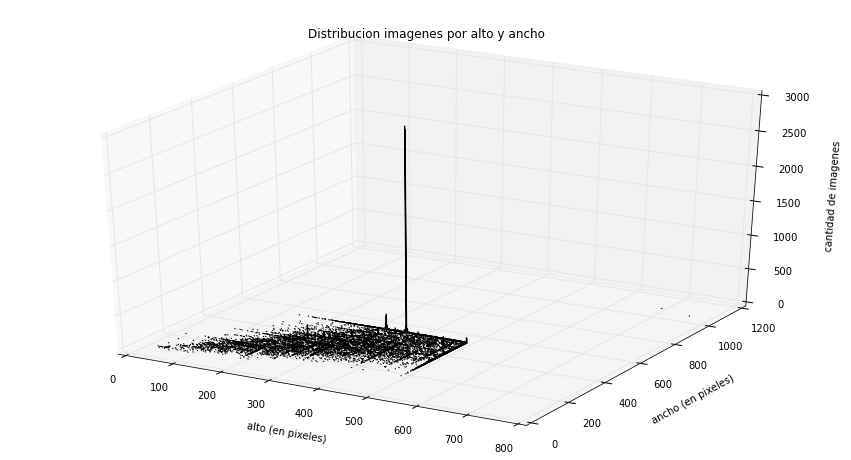

In [4]:
problem = tp2.Problem()
problem.read_problem()

img_filenames = problem.img_filenames
img_filenames = sorted(img_filenames, key= lambda name: int(name[name.index('.')+1:name.rindex('.')]))

d = {}
for filename in img_filenames:
    img = cv2.imread(filename)
    if img.shape in d.keys():
        d[ img.shape ] += 1
    else:
        d[ img.shape ] = 1

xs = [t[0] for t in d.keys()]
ys = [t[1] for t in d.keys()]
z  = [d[k] for k in d.keys()]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar(xs, z, zs=ys, zdir='y')

ax.set_title('Distribucion imagenes por alto y ancho')
ax.set_xlabel('alto (en pixeles)')
ax.set_ylabel('ancho (en pixeles)')
ax.set_zlabel('cantidad de imagenes')
plt.show()

In [9]:
print "Detalles"
print "Alto:"
print "mean: "+str(round(np.mean(xs),2))+"px\t","max: "+str(max(xs))+"px\t","min: "+str(min(xs))+"px"
print
print "Ancho:"
print "mean: "+str(round(np.mean(ys),2))+"px\t","max: "+str(max(ys))+"px\t","min: "+str(min(ys))+"px"

Detalles
Alto:
mean: 320.66px	max: 768px	min: 32px

Ancho:
mean: 325.73px	max: 1050px	min: 42px


Desde ya, creemos que la distribución del conjunto de datos podría ser fuertemente explotada. Durante la experimentación preliminar, se utilizó también un conjunto reducido de las imágenes de tamaño *374$\times$500* píxeles, dado que son las más frecuentes. De esta forma, es posible aplicar los algoritmos sin necesidad de redimensionar las imágenes (lo cual podría aplicar ruído sobre el set de entrenamiento), usando un set de datos normalizado. No encontramos mejoras considerables, por lo que decidimos no continuar en esta dirección, y utlizar imágenes de tamaño variable, redimensionando cuando sea necesario. De todas maneras, nos parece interesante mencionar a esta altura que un análisis más sofisticado y preprocesamiento sobre el conjunto de datos original podría impactar en los resultados de la clasificación.

Para poder correr nuestras pruebas y poder reportar resultados, dividimos inicialmente el conjunto de datos en dos subconjuntos: Uno para *desarrollo* y otro para *validación* de los resultados conteniendo el 80% y 20% de los datos respectivamente.  

Ya que el tamaño del dataset de desarrollo es lo suficientemente grande, tomamos una porción menor para las distintas pruebas en donde fuimos variando la cantidad de datos de entrenamiento utilizado con el objetivo de obtener resultados en tiempos razonables para cumplir con el objetivo del trabajo. 

Luego, para el mejor modelo que se obtenga en la etapa de desarrollo, analizaremos el resultado final utilizando la totalidad de los datos de validación. Agregaremos también el resultado final sobre el [conjunto de test](https://www.kaggle.com/c/dogs-vs-cats/download/test1.zip) provisto por Kaggle para la competencia.

A continuación se separa el conjunto de datos original y se reportan información relacionada con la cantidad de instancias en cada conjunto.

Full dataset instances 24998
# dogs: 12499
# cats: 12499
Develompent size (fast):  4000
Develompent size (full):  19998
Validation size:  5000
# Perros en dev: 1972
# Gatos en dev: 2028


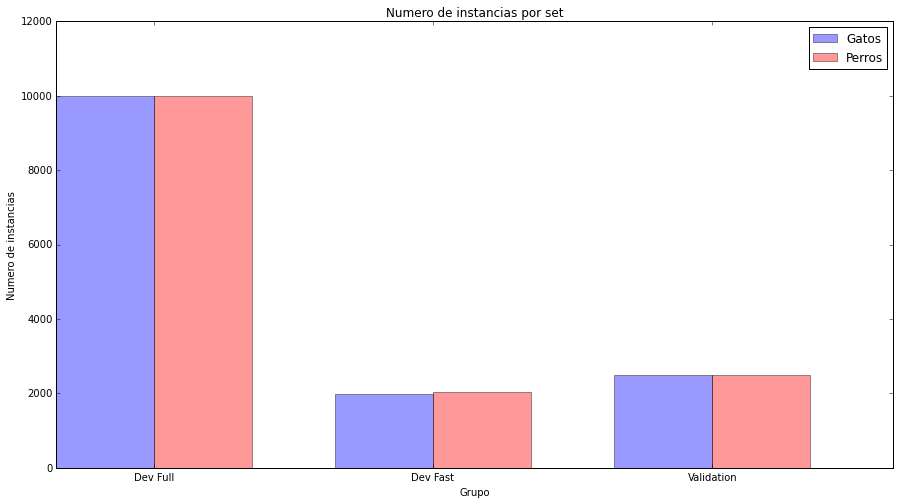

In [16]:
problem = tp2.Problem()
X, y = problem.read_problem()
y = y*1

print "Full dataset instances", len(X)

print "# dogs:", sum(problem.img_tags)
print "# cats:", len(problem.img_tags) - sum(problem.img_tags)

# Dev-Test sets.
X_dev_full, X_val, y_dev_full, y_val = sklearn.cross_validation.train_test_split(X, y, test_size=0.20, random_state=123)

X_dev = X_dev_full[0:4000]
y_dev = np.array(y_dev_full[0:4000])

print "Develompent size (fast): ", len(X_dev)
print "Develompent size (full): ", len(X_dev_full)
print "Validation size: ", len(X_val)   

_ = tp2.plot_bars(y_dev_full, y_dev, y_val)
print "# Perros en dev:", sum(y_dev)
print "# Gatos en dev:", len(y_dev) - sum(y_dev)


## Algoritmos de clasificación utilizados


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from VotingClassifier import VotingClassifier # from file

classifiers = []
results = {}

En todos los casos, se utilizán las implementaciones de modelos de ensamble provistas por [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html).

### Clasificador 1: Random Forest Classifier

Este modelo de ensamble consiste en combinar una cantidad parametrizable de árboles de decisión, donde cada árbol se construye utilizando un conjunto del tamaño del conjunto original, en donde cada instancia se elige aleatoriamente con reposición sobre total.

Lo que distingue de la técnica de Bagging es que, en caso de haber un predictor muy fuerte, esta variable siempre quedará como *top-split*. Para evitar esto, la técnica de Random Forest trabaja en cada paso de la construcción del árbol con un subconjunto aleatorio de variables para evitar este problema.

Uno de los puntos interesantes de esta técnica es que no produce overfitting a medida que se agregan más modelos al ensamble.


In [8]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
classifiers.append(("Random Forest Classifier", clf1))


### Clasificador 2: Extra Trees Classifier


A diferenmcia de random forest, este clasificador agrega un nivel más de aleatoriedad en la selección de la variable corte. En vez de elegir la variable que maximiza la ganancia de información (sobre un subconjunto elegido aleatoriamente), considera una variable entre estas al azar.

Para una descripción más completa ver: [Geurts et al (2006)](http://orbi.ulg.ac.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf).


In [9]:
clf2 = ExtraTreesClassifier(n_estimators=100, random_state=0)
classifiers.append(("Extra Trees Classifier", clf2))


### Clasificador 3: Gradient Boosting Classifier 

En el caso del Gradient Boosting Classifier, es un algoritmo en donde cada árbol se construye secuencialmente a partir de un árbol anterior reutilizando parte del árbol e enfocandose poder predecir valores que el árbol anterior no pudo.

El peso de importancia ($\lambda$) que se le da al árbol anterior, es un parámetro a optimizar.

Para una descripción más completa ver: [Gradient Tree Boosting](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting).


In [10]:
clf3 = GradientBoostingClassifier(random_state=0)
classifiers.append(("Gradient Boosting Classifier", clf3))


### Clasificador 4: Ada Boost Classifier

La idea de este modelo es utilizar inicialmente un clasificador construído sobre el conjunto de datos original. Además, construye copias adicionales del modelo original donde cada una de las muestras que fueron clasificadas incorrectamente son pesadas de forma que cada nuevo clasificador ponga el foco en clasificar las instancias más difíciles.

Para una descripción más completa ver: [Ada Boost Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier).

In [11]:
clf4 = AdaBoostClassifier(n_estimators=100, random_state=0)
classifiers.append(("Ada Boost Classifier", clf4))


### Clasificador 5: Voting Classifier 

Finalmente, este modelo se construye utilizando un conjunto de clasificadores (modelos) donde la predicción final se decide en base a la clasificación de cada modelo individual a través de un sistema de votación. Existen 2 versiones sobre cómo realizar esta votación: *hard*, donde la predición final es simplemente la moda de las predicciones de todos los modelos, y *soft* donde la predicción final está basada en las probabilidades de las predicciones de cada modelo.

Para una descripción más completa ver: [VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

In [12]:
clf5 = VotingClassifier(estimators=[('rf', clf1), ('et', clf2), ('gb', clf3), ('ada', clf4)], voting='soft')
classifiers.append(("Voting Classifier", clf5))


### Funciones para evaluar los clasificadores

Para analizar el desempeño de los diferentes métodos, decidimos construir la matriz del confusión sobre cada técnica, fijando los parámetros de cada clasificador, si bien como se indica al final del trabajo, un estudio detallado sobre el impacto de variar cada uno de estos podría resultar de interés. De todas maneras, no es el objetivo del trabajo buscar buenas combinaciones de parámetros, sino que queremos tener una primera aproximación sobre el impacto de las distintas formas de extraer atributos presentadas anteriormente. 

In [13]:
from sklearn.metrics import confusion_matrix
        
def classifiers_scores(X_train, y_train, X_test, y_test):
    classifiers_results = {}
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        classifiers_results[name] = confusion_matrix(y_test, y_pred, labels=[0,1])
    return classifiers_results

Consideramos además la técnica de [K-fold cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html). En particular, la variante StratifiedKFold utilizada asegura que cada partición preserva el porcentaje de muestras para cada clase. La cantidad de particiones utilizadas se fijó en 2.

In [14]:
skf = sklearn.cross_validation.StratifiedKFold(y_dev, n_folds=2, random_state=0)

def test_algorithm(extraction_algorithm, algorithm_name):
    X_features = extraction_algorithm(X_dev)
    results[algorithm_name] = {}
    
    for i, (train_index, test_index) in enumerate(skf):
        print "Fold", i+1
        X_train, X_test = X_features[train_index], X_features[test_index]
        y_train, y_test = y_dev[train_index], y_dev[test_index]

        classifiers_results = classifiers_scores(X_train, y_train, X_test, y_test)
        results[algorithm_name][i+1] = classifiers_results

## Técnicas de extracción de características principales junto a los resultados logrados

A continuación se aplican cada una de las técnicas de clasificación mencionadas en las secciones anteriores. En todos los casos, los parámetros fueron ajustados en base a experimentación acotada. En particular:

* En la ténica que considera los píxeles como un atributo, donde luego se aplica PCA y finalmente los algotimos de clasificación, se fijó la cantidad de componentes principales en 50, observando la cantidad de varianza capturada.

* Para la técnica que trabaja con el histograma, se consideró utilizar la concatenación del histograma de cada canal RGB de la imagen, como el vector de atributos final.

* En la técnica que cuenta la cantidad de bloques para cada patrón posible, también se trabajó sobre cada canal RGB por separado, y se fijó el tamaño de bloque en 3x3, considerando las imágenes redimensionadas en 80x80 píxeles.

* Para el conteo de Local Binary Patterns, la vecindad observada está determinada por la circunferencia cuyo radio fijamos en 1, utilizando 8 píxeles vecinos.

En todos los casos, como dijimos anteriormente, los parámetros se ajustaron en base a experimentación preliminar, y proponemos como trabajo a futuro un estudio detallado sobre el impacto de cada uno de estos en los diferentes métodos.

In [ ]:
# PCA
from sklearn.decomposition import PCA

X_dev_pixels = tp2.read_pixels(X_dev)

pca = PCA(n_components=50)
results["PCA"] = {}

for i, (train_index, test_index) in enumerate(skf):
    print "Fold", i+1
    X_train, X_test = X_dev_pixels[train_index], X_dev_pixels[test_index]
    y_train, y_test = y_dev[train_index], y_dev[test_index]
    
    X_train_reduced = pca.fit_transform(X_train, y_train)
#     print "PCA: % of variance captured:", np.sum(pca.explained_variance_ratio_)
    X_test_reduced = pca.transform(X_test)
    
    classifiers_results = classifiers_scores(X_train_reduced, y_train, X_test_reduced, y_test)
    results["PCA"][i+1] = classifiers_results
    


In [ ]:
# Análisis del histograma de la imagen 
test_algorithm(tp2.read_histograms, "Histogramas")

In [ ]:
# Patrones de cuadros (patches)
test_algorithm(tp2.extract_patches_count, "Patches")

In [ ]:
# Cambios de intensidad de un pixel con todos (pixel connections)
test_algorithm(tp2.extract_pixels_connections, "Pixel Connections")

In [ ]:
# LBP: Local Binary Patterns Count
test_algorithm(tp2.extract_lbp_count, "LBP Count")

#### Guardando los resultados:

In [ ]:
pickle.dump( results, open( "results-size-{}.p".format(len(y_dev)), "wb" ) )

### Analizando resultados

A continuación se reporta una versión simplificada de los resultados obtenidos. Se observa el *mean accuracy* entre las particiones del 2-fold cross-validation, en función del tamaño del conjunto de datos utilizado para entrenamiento, discriminando por técnica de extracción de atributos.

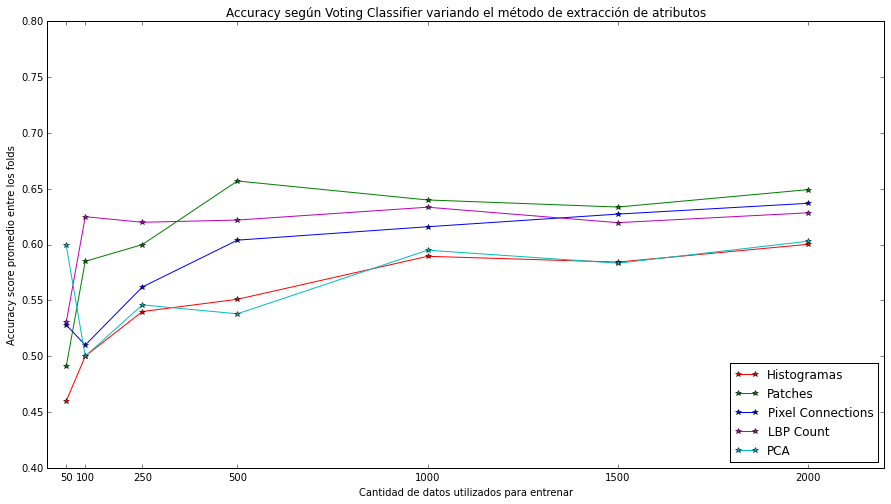

In [4]:
measure = "Accuracy"
fig = plt.figure(0)
dev_set_sizes = np.array([100, 200, 500, 1000, 2000, 3000, 4000])
colors = ['r', 'g', 'b', 'm', 'c']
for m_id, method in enumerate(["Histogramas", "Patches", "Pixel Connections", "LBP Count", "PCA"]):
    y = []
    for i in dev_set_sizes:
        res = pickle.load( open( "results/results-size-{}.p".format(i), "rb" ) ) 
        n = (tp2.accuracy(res[method][1]["Voting Classifier"]) + tp2.accuracy(res[method][2]["Voting Classifier"]))/2.0
        y.append(n)
    plt.plot(dev_set_sizes/2, y, colors[m_id] + '*-', label=method)
plt.xlim((0, 2200))
plt.ylim((0.4, 0.8))
plt.xlabel("Cantidad de datos utilizados para entrenar")
plt.ylabel("{} score promedio entre los folds".format(measure))
plt.title("{} según Voting Classifier variando el método de extracción de atributos".format(measure).decode('utf8'))
plt.xticks(dev_set_sizes/2)
plt.legend(loc=4)
plt.show()

### Selección del mejor modelo

Basándose en la métrica *mean accuracy* de los resultados obtenidos, destacamos el desempeño que se observa para la técnica basada en patrones de cuadros (texturas) con 2000 datos de entrenamiento como método de extracción de atributos.

Luego, consideramos los distintos clasificadores probados quedándonos finalmente con *Voting Classifier*, en el cual obtuvimos el mayor valor de accuracy promedio entre los folds.

Aunque en el gráfico anterior puede observarse un pico en 500 datos de entrenamiento, creemos que el mismo puede ser consecuencia del azar, y no al hecho de haber encontrado un mejor modelo. Sería pertinente evaluar una mayor cantidad de folds, así como también nuevos subconjuntos del set de datos de desarrollo para experimentar, buscando atenuar este tipo de efectos. Nuevamente, por cuestiones de tiempo, proponemos esto como trabajo a futuro.

A continuación, un ejemplo en donde puede verse el valor de las métricas sobre 4000 datos en desarrollo (es decir, 2000 entrenamiento) para un fold determinado.

In [5]:
res_4000 = pickle.load( open( "results/results-size-4000.p", "rb" ) ) 
res_4000 = res_4000["Patches"][2]
print "Resultados para el set de desarrollo de tamaño 4000 (2000 datos de entrenamiento) para el método de patrones cuadrados (patches):"
tp2.DictTable(res_4000)


Resultados para el set de desarrollo de tamaño 4000 (2000 datos de entrenamiento) para el método de patrones cuadrados (patches):


{'Ada Boost Classifier': array([[670, 345],
        [407, 578]]), 'Extra Trees Classifier': array([[693, 322],
        [438, 547]]), 'Gradient Boosting Classifier': array([[717, 298],
        [397, 588]]), 'Random Forest Classifier': array([[693, 322],
        [391, 594]]), 'Voting Classifier': array([[708, 307],
        [388, 597]])}

Se puede observar que el accuracy final obtenido por los diferentes modelos es similar, si bien el mayor valor lo obtiene *Voting Classifier*. Una tendencia que notamos es que los modelos tienden a tener facilidad para reconocer gatos, donde la precission sobre gatos es aproximadamente 10% mejor que la precission sobre perros, en cada caso. Creemos que sería interesante hacer un estudio más detallado en esta dirección.

## Validando el resultado

Como prueba final, evaluamos el mejor modelo obtenido construyéndolo con 4000 instancias de los datos de entrenamiento y probando sobre nuestros datos de validación (5000 instancias).

Los resultados obtenidos son los siguientes:

In [17]:
clf = VotingClassifier(estimators=[('rf', clf1), ('et', clf2), ('gb', clf3), ('ada', clf4)], voting='soft')

from sklearn.externals import joblib
X_dev_features = tp2.extract_patches_count(X_dev)
clf.fit(X_dev_features, y_dev)
_ = joblib.dump(clf, 'modelo/best-model.pkl')    # Para guardar el modelo

In [88]:
clf = joblib.load('modelo/best-model.pkl') # Para cargar el modelo
X_val_features = tp2.extract_patches_count(X_val)
y_pred = clf.predict(X_val_features)
res = sklearn.metrics.confusion_matrix(y_val, y_pred, labels=[0,1])
pickle.dump( res, open( "resultado-final.p", "wb" ) ) 

In [3]:
res =  pickle.load(open( "resultado-final.p", "rb" ))
tp2.ConfusionTable(res)

El resultado obtenido sobre el conjunto de validación es consistente con los valores observados para el conjunto de datos de desarrollo. Nuevamente, se observa que la precission sobre gatos es ~9% mayor que la precission en perros, siendo de ~69% y ~60% respectivamente.

Finalmente, decidimos comparar nuestros resultados utilizando el [conjunto de test](https://www.kaggle.com/c/dogs-vs-cats/download/test1.zip) provisto por Kaggle:

In [20]:
clf = joblib.load('modelo/best-model.pkl') # Para cargar el modelo

kaggle_testfolder = "/home/tobi/Repositories/aprendizaje-automatico-ejercicios/tp2/datasets/test1/"
kaggle_testfilenames = glob.glob(kaggle_testfolder + "/*.jpg")
kaggle_testfilenames = sorted(kaggle_testfilenames, key= lambda name: int(name[name.rindex('/')+1:name.index('.')]))

X_val_features = tp2.extract_patches_count(kaggle_testfilenames)
y_pred = clf.predict(X_val_features)
pickle.dump( y_pred, open( "resultado-final-kaggle.p", "wb" ) )

all patches extracted.


In [ ]:
# Script para generar el archivo solución para Kaggle
header = "id,label\n"
solution_filename = 'solution-kaggle.csv'
with open(solution_filename,'w') as fout:
    fout.write(header)
    for i in xrange(len(y_pred)):
        row = str(i+1)+","+str(int(y_pred[i]))+"\n"
        fout.write(row)

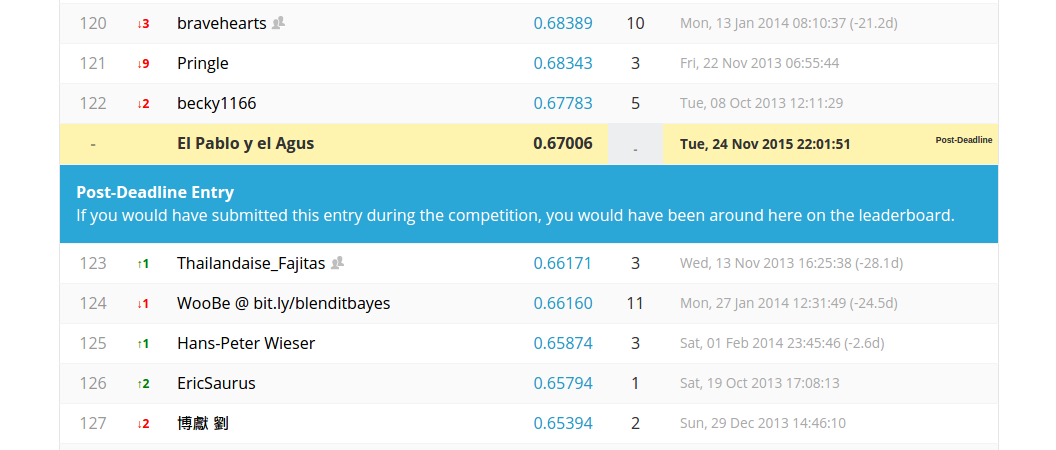

In [9]:
from PIL import Image                                                                                
Image.open('kaggle1.png')

Si bien el resultado sobre el conjunto de datos de Kaggle fue superior al obtenido en nuestros experimentos, creemos que el desempeño sigue siendo bajo. En la última Sección sobre *Conclusiones y trabajo a futuro*, desarrollamos algunas de las ideas que creemos podrían mejorar la performance de las diferentes técnicas.

Nos hubiese gustado obtener algo similar a la siguiente imagen:

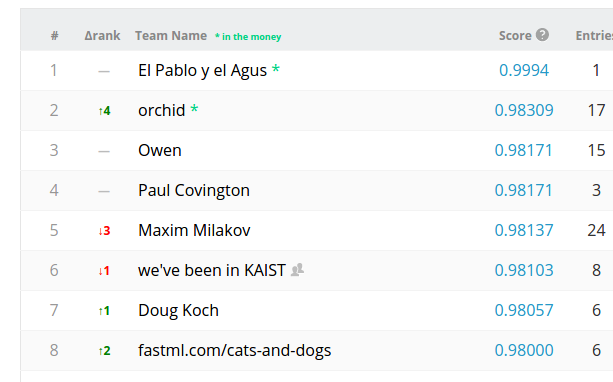

In [10]:
Image.open('kaggle2.png')

## Conclusiones y trabajo futuro

Durante el trabajo aplicamos técnicas de aprendizaje supervizado dentro de un contexto de clasificación de imágenes para distinguir imágenes de perros y gatos. El foco estuvo en las diferentes formas de extraer atributos de una imagen, y los resultados muestran que hay diferencias en la performance de cada una de estas, y que el incluir información de las texturas y la relación que hay entre píxeles de la imagen, produce mejoras (leves) por sobre técnicas que solo consideran los valores de los píxeles.

Por otro lado, no estamos conformes con el desempeño final obtenido (accuracy aproximada de 67%), y pudimos tener una idea práctica de la dificultad del problema planteado. Sin embargo, también entendemos que el estudio del problema se realizó en un marco acotado, y es por esto que no queremos dejar de proponer las siguientes ideas como trabajo a futuro:

* Más experimentación sobre los parámetros: hay una gran cantidad de parámetros, tanto en las técnicas de extracción de atributos como en los algoritmos de clasificación, sobre los cuales se realizó una acotada experimentación. Creemos que sería conveniente realizar un mayor estudio para ver el impacto de estos, o incluso construir un clasificador basado en [Grid Search](http://scikit-learn.org/stable/modules/grid_search.html).

* Features relacionados con el dominio del problema: en todos los casos, los atributos que proponemos son ortogonales al dominio particular del problema. Proponemos realizar un estudio particular sobre procesamiento de imágenes relacionadas al dominio de perros y gatos para capturar atributos intrínsecos del problema. También nos parece valioso observar que con atributos genéricos de clasificación de imágenes, el desempeño de las técnicas es no despreciable.

* Utilizar mayor cantidad de muestras: no consideramos nunca utilizar el conjunto de datos completo propuesto por Kaggle. Junto con una mayor experimentación de parámetros, también podríamos considerar considerar conjuntos de entrenamiento más grandes, esperando que incrementar (hasta cierto punto) la cantidad de muestras, permita obtener mejores resultados.

* Usar redes neuronales o SVMs: otra opción sería considerar modelos más sofísticados como redes neuronales que permitan extraer atributos complejos, o incluso modelos más clásicos como SVMs.

* Detección de caras: creemos que sería interesante considerar clasificadores basados en la detección de rostros, usando por ejemplo el [Cascade Classifier](
http://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html) de [OpenCV](http://opencv.org/).

Finalmente, creemos que el problema es desafiante y encontramos interesante poder experimentar con algunas de las diferentes herramientas vistas en la materia.